In [67]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import os
#from glob 
import glob
import itertools
from tqdm.notebook import tqdm

import re
import pickle

In [2]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [3]:
DATA = './data'
MY_DATA = './my_data'
ANSW = './answers'

In [87]:
import statsmodels.api as sm
import scipy.stats as sts
from statsmodels.stats.proportion import proportion_confint

In [59]:
path_to_csv = os.path.join(DATA, '150users/')

In [76]:
mins = []
maxs = []
for file_csv in tqdm((sorted(glob.glob(path_to_csv + '/*.csv')))):
    tmp_file = pd.read_csv(file_csv, parse_dates=['timestamp'])
    mins.append(tmp_file.timestamp.min())
    maxs.append(tmp_file.timestamp.max())

In [78]:
min(mins), max(mins)

(Timestamp('2013-11-15 08:01:09'), Timestamp('2014-03-24 16:23:09'))

In [79]:
min(maxs), max(maxs)

(Timestamp('2014-01-13 14:50:45'), Timestamp('2014-05-28 19:10:15'))

In [5]:
def prepare_train_set_with_fe(path_to_csv, site_freq_path, feature_names,
                                    sess_len=10, wind_size=10):
    
    rows = 0
    
    # load site freq indexes
    with open(site_freq_path, 'rb') as f:
        freq_site_dict = pickle.load(f)
    
    # getting size of output DataFrame
    for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
        temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
        #site_cnt += list(temp_dataframe.site.values)
        rows += round(temp_dataframe.shape[0] / wind_size + 0.499)
    
    ret_data = pd.DataFrame(index = range(rows), columns = feature_names)
    index = 0
    

    # prepare output DataFrame
    for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
            temp_dataframe = pd.read_csv(file_csv, parse_dates=['timestamp'])
            userid = int(re.findall('\d+', file_csv)[1])

            #forming rows of output DataFrame
            sess_numb = round(temp_dataframe.shape[0] / wind_size + 0.499)
            for idx in range(sess_numb - 1):
                new_sess = {el:0 for el in feature_names}
                
                sess_start = idx*wind_size
                sess_end   = idx*wind_size + sess_len


                for n, idx in enumerate(range(sess_start,sess_end)):
                    new_sess['site' + str(n+1)] = freq_site_dict[temp_dataframe.loc[idx,'site']][0]
                    if idx < (sess_end - 1):
                        new_sess['time_diff' + str(n)] = (temp_dataframe.loc[idx + 1, 'timestamp'] - \
                                                temp_dataframe.loc[idx, 'timestamp']).total_seconds()
                
                
                new_sess['target'] = userid
                new_sess['#unique_sites'] = len(set(temp_dataframe.site.values[sess_start : sess_end]))
                new_sess['session_timespan'] = (temp_dataframe.loc[sess_end - 1, 'timestamp'] - \
                                                temp_dataframe.loc[sess_start, 'timestamp']).total_seconds() 
                new_sess['start_hour'] = temp_dataframe.loc[sess_start, 'timestamp'].hour 
                new_sess['day_of_week'] = temp_dataframe.loc[sess_start, 'timestamp'].weekday() 
                
                #put data in prepared DataFrame
                ret_data.iloc[index] = new_sess
                index += 1

                
            sess_start = idx*10
            sess_end   = temp_dataframe.shape[0]
            #forming las row of output DataFrame
            new_sess = {el:0 for el in feature_names}
            for n, idx in enumerate(range(sess_start,sess_end)):
                new_sess['site' + str(n+1)] = freq_site_dict[temp_dataframe.loc[idx,'site']][0]
                if idx < (sess_end - 1):
                    new_sess['time_diff' + str(n)] = (temp_dataframe.loc[idx + 1, 'timestamp'] - \
                                            temp_dataframe.loc[idx, 'timestamp']).total_seconds()
            new_sess['target'] = userid
            new_sess['#unique_sites'] = len(set(temp_dataframe.site.values[(sess_numb-1)*wind_size: ]))

            new_sess['session_timespan'] = (temp_dataframe.iloc[-1].timestamp - \
                                            temp_dataframe.loc[(sess_numb-1)*wind_size, 'timestamp']).total_seconds()
            new_sess['start_hour'] = temp_dataframe.loc[(sess_numb-1)*wind_size, 'timestamp'].hour  
            new_sess['day_of_week'] = temp_dataframe.loc[(sess_numb-1)*wind_size, 'timestamp'].weekday()    
                
            #ret_userid_list.append(userid)

            ret_data.iloc[index] = new_sess
            index += 1
            
            
            
            
    return ret_data

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [88]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(MY_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, sess_len=10)

train_data_10users.head()

Wall time: 14.9 s


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,...,1,0,1,0,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,...,1,3,3,8,0,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,...,0,1,0,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,...,1,0,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,...,0,1,1,0,0,6,9,8,4,31


In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(MY_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, sess_len=10)

train_data_150users.head()

Wall time: 2min 25s


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,4,2,1,4,1,2,1290,321,...,1,0,49,0,0,57,5,8,4,6
1,2,23,1505,1290,321,321,113,73,49,49,...,73,0,1504,4,0,1618,8,8,4,6
2,321,205,1,1,1,1,73,321,2,1,...,56,1917,0,4,0,2010,5,8,4,6
3,1,1,6998,6998,5491,6998,6998,1,35,1,...,420,1460,6,0,0,2006,4,9,4,6
4,1,1,76,1,58,50,58,50,83,76,...,1,0,1,0,0,10,5,9,4,6


In [56]:
train_data_150users.keys()

Index(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3',
       'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8',
       'time_diff9', 'session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'target'],
      dtype='object')

In [19]:
proportion = train_data_150users.groupby('target').agg('size').values
print(min(proportion), np.mean(proportion), max(proportion))

351 913.46 4653


In [43]:
layout = go.Layout(
    autosize=False,
    width=800,
    height=800)


In [52]:
#labels = ['Минимальная пропория', 'Общее количество']
#values = [min(proportion), train_data_150users.shape[0]]

# pull is given as a fraction of the pie radius
#fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.1])], layout=layout)
#fig.show()

In [53]:
#labels = ['Средняя пропория', 'Общее количество']
#values = [np.mean(proportion), train_data_150users.shape[0]]

# pull is given as a fraction of the pie radius
#fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.1])], layout=layout)
#fig.show()

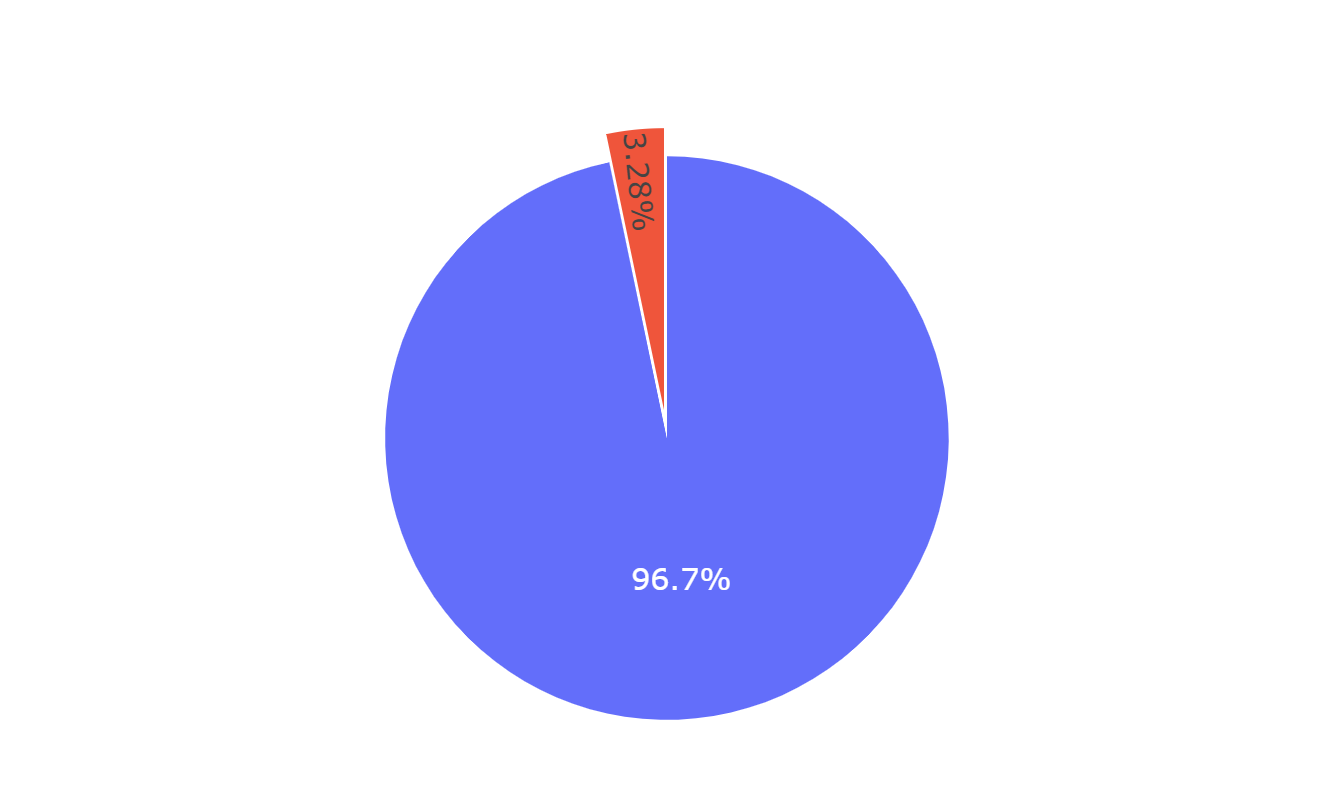

In [55]:
labels = ['Максимальная пропория', 'Общее количество']
values = [max(proportion), train_data_150users.shape[0]]

# pull is given as a fraction of the pie radius
fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.1])], layout = layout)
fig.update_traces(textposition='inside', textfont_size=30)
fig.update_layout(showlegend=False)
fig.show()

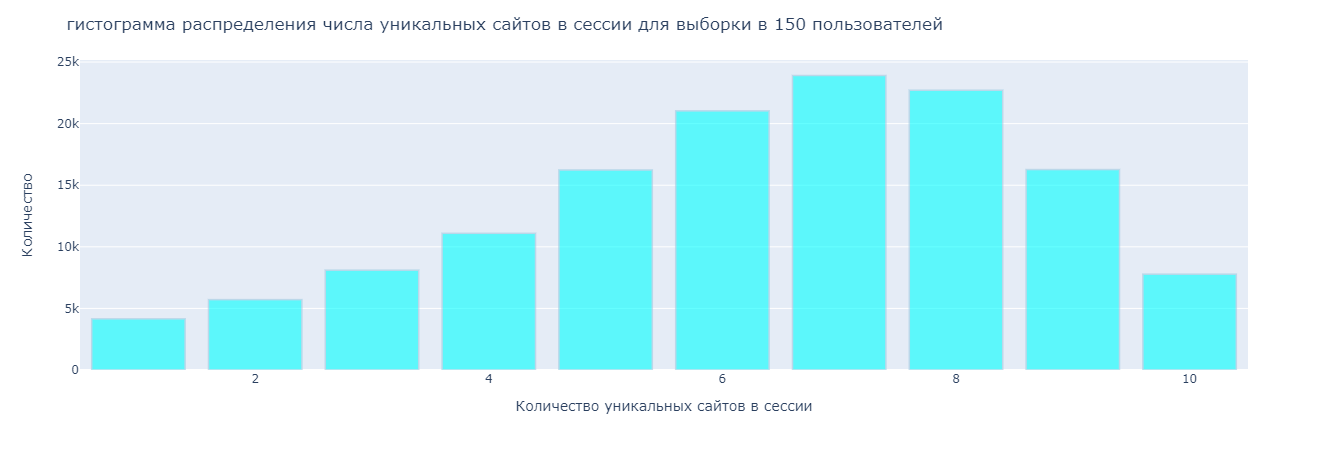

In [116]:
fig = px.bar(x = train_data_150users['#unique_sites'].value_counts().keys(),
             y = train_data_150users['#unique_sites'].value_counts(), 
)

fig.update_traces(marker_color='aqua',
                  marker_line_color = 'rgb(158,202,225)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title=u'гистограмма распределения числа уникальных сайтов в сессии для выборки в 150 пользователей',
    xaxis_title=u'Количество уникальных сайтов в сессии',
    yaxis_title=u'Количество ',
    )
fig.show()

In [92]:
nuniq10 = train_data_10users['#unique_sites']#.value_counts()
nuniq150 = train_data_150users['#unique_sites']#.value_counts()

In [93]:
stat, p = sts.shapiro(nuniq10)
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=0.955, p=0.00000000


C:\Users\_v010ch_\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



In [94]:
stat, p = sts.shapiro(nuniq150)
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=0.953, p=0.00000000


In [109]:
hour10 = train_data_10users['start_hour']#.value_counts()
hour150 = train_data_150users['start_hour']#.value_counts()

In [110]:
stat, p = sts.shapiro(hour10)
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=0.963, p=0.00000000


In [111]:
stat, p = sts.shapiro(hour150)
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=0.956, p=0.00000000


In [112]:
dow10 = train_data_10users['day_of_week']#.value_counts()
dow150 = train_data_150users['day_of_week']#.value_counts()

In [113]:
stat, p = sts.shapiro(dow10)
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=0.926, p=0.00000000


In [114]:
stat, p = sts.shapiro(dow150)
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=0.920, p=0.00000000


In [141]:
Ashley = 207
Naomi =  237
Bob = 31

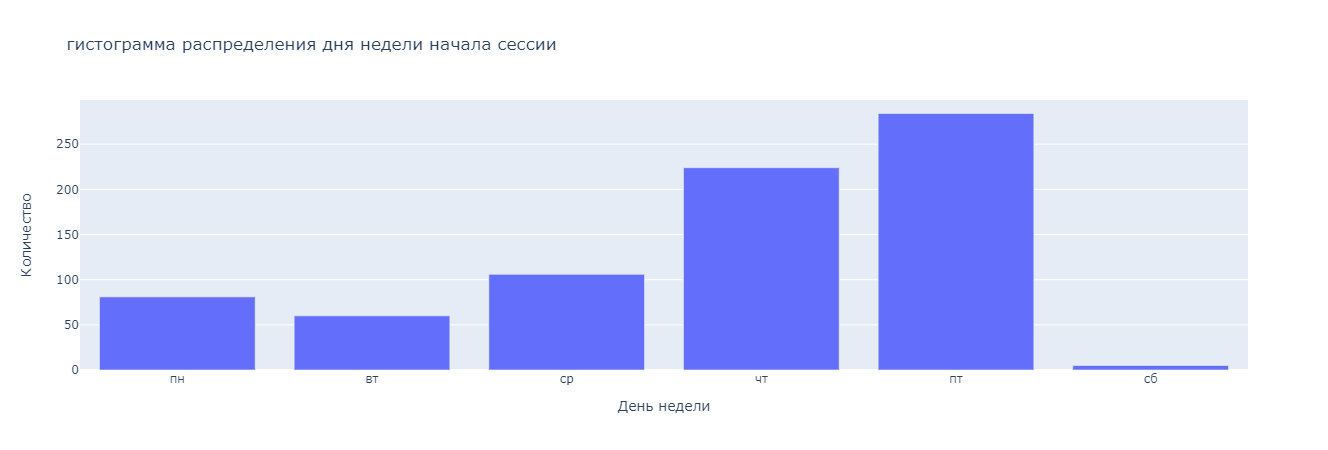

In [142]:
idx = train_data_10users.target == Bob
bar = go.Bar(y = train_data_10users.loc[idx, 'day_of_week'].value_counts(),
                      x = train_data_10users.loc[idx, 'day_of_week'].value_counts().keys()
                    , name = 'Ashley'
                    )
fig = go.Figure([bar])
fig.update_layout(
    title=u'гистограмма распределения дня недели начала сессии',
    xaxis_title=u'День недели',
    yaxis_title=u'Количество ',
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ['пн','вт','ср','чт','пт','сб','вс']
    ))
fig.show()

In [ ]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

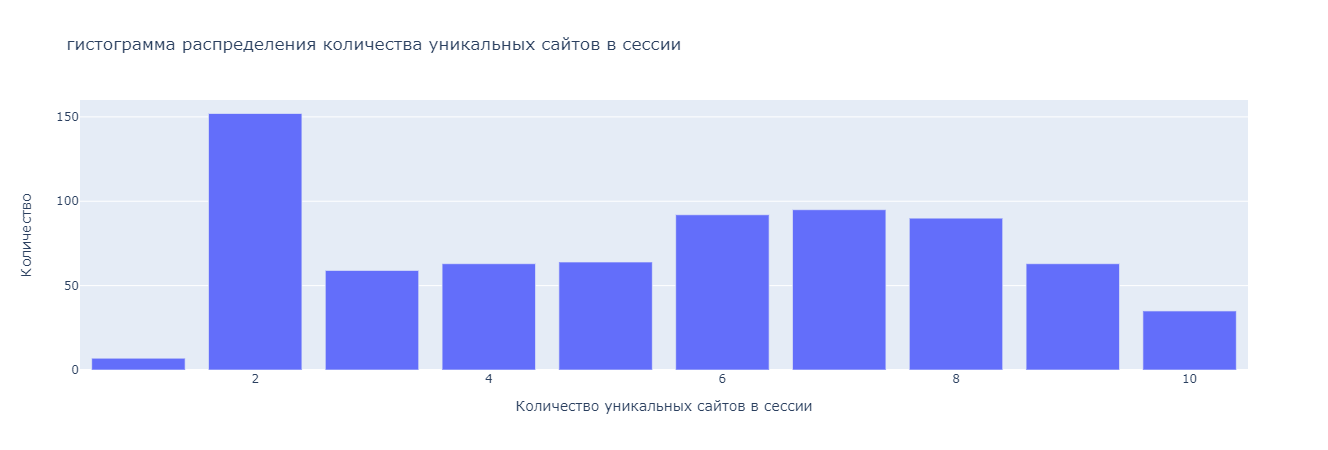

In [157]:
idx = train_data_10users.target == 100
bar = go.Bar(y = train_data_10users.loc[idx, '#unique_sites'].value_counts(),
                      x = train_data_10users.loc[idx, '#unique_sites'].value_counts().keys()
                    , name = 'Ashley'
                    )
fig = go.Figure([bar])
fig.update_layout(
    title=u'гистограмма распределения количества уникальных сайтов в сессии',
    xaxis_title=u'Количество уникальных сайтов в сессии',
    yaxis_title=u'Количество ',
    )
fig.show()

In [143]:
train_data_10users.keys()

Index(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3',
       'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8',
       'time_diff9', 'session_timespan', '#unique_sites', 'start_hour',
       'day_of_week', 'target'],
      dtype='object')